In [1]:
# !pip install arxiv

In [1]:
import os
import sys

# Get the current working directory and add the parent directory to the Python path
current_working_directory = os.getcwd()
sys.path.append(os.path.join(current_working_directory, "../.."))

In [2]:
import pprint

### Defining the Graph state

In [3]:
from typing import TypedDict, Annotated, List, Union
from langchain_core.agents import AgentAction, AgentFinish
from langchain_core.messages import BaseMessage
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
import operator
from IPython.display import Image, display

In [4]:
class AgentState(TypedDict):
    input: str
    agent_outcome: Union[AgentAction, AgentFinish, None]
    intermediate_step: Annotated[list, operator.add]
    doc_schema: List[BaseMessage]
    revision_number: int = -1
    max_revisions: int


### Defining Tools

In [5]:
tools = []

#### Search Tools

In [6]:
from langchain_community.tools.arxiv.tool import ArxivQueryRun
from langchain_community.tools.tavily_search import TavilySearchResults

arxiv_search = ArxivQueryRun()
tavily_tool = TavilySearchResults(max_results=5)

search_tools = [arxiv_search, tavily_tool]
search_tools = [arxiv_search]

In [7]:
tools.extend(search_tools)

#### File Tools

In [8]:
import uuid
session_id = uuid.uuid4()
session_id = "ai_survey_456"
print(session_id)

from langchain_community.agent_toolkits import FileManagementToolkit
working_directory = "./input_files/{session_id}/".format(session_id=session_id)

file_tools = FileManagementToolkit(
    root_dir=working_directory,
    selected_tools=["read_file", "write_file", "list_directory"],
).get_tools()
read_tool, write_tool, list_tool = file_tools

ai_survey_456


In [9]:
read_tool

ReadFileTool(root_dir='./input_files/ai_survey_456/')

In [10]:
tools.extend(file_tools)

In [11]:
import json
from langchain_core.messages import ToolMessage

class BasicToolNode:
    def __init__(self, tools: list) -> None:
        self.tools_by_name = {tool.name: tool for tool in tools}

    def __call__(self, inputs: dict):
        print("----tool calling----")
        message = inputs["agent_outcome"][-1]

        outputs = []
        for tool_call in message.tool_calls:
            print(f"---- Calling {tool_call['name']} with args: {tool_call['args']} ----")
            tool_result = self.tools_by_name[tool_call["name"]].invoke(
                tool_call["args"]
            )
            outputs.append(
                ToolMessage(
                    content=json.dumps(tool_result),
                    name=tool_call["name"],
                    tool_call_id=tool_call["id"],
                )
            )

        return {
                "agent_outcome": outputs,
                "intermediate_step": [str(outputs)]
            }

### Model 

In [12]:
from models.llm import LLM

model = LLM('gpt-4o')
llm = model.load_model()

### Agent Workflow

In [13]:
from langgraph.graph import END, StateGraph
workflow = StateGraph(AgentState)

#### Agents & Nodes

##### Researcher

In [14]:
def research_agent(data):
    print("----research node----")
    # print("\n", data["agent_outcome"], "\n")
    prompt = ChatPromptTemplate.from_messages(
        [
            (
                "system",
                "You are a researcher charged with providing information that can be used when writing the following literature review."
                " Given a query, identify similar and relevant topics."
                " For each topic and input user query generate a few relevant search querries."
                " Use the appropriate search tools for finding the relevant results for all the search querries."
                " Once you have the relevant search results, create a directory input_docs, if not present, and dump each result (title, authors, summary or context) separately in a file using Title as the file name."
                "\nYou have access to the following search tools: {tool_names}."
            ),
            (
                "human",
                "\nUser Query: {input}"
            ),
            
            MessagesPlaceholder(variable_name="intermediate_step"),
        ]
    )
    
    prompt = prompt.partial(tool_names=", ".join([tool.name for tool in tools]))
    agent = prompt | llm.bind_tools(tools)
    result = agent.invoke(data)
    return {'agent_outcome': [result]}

workflow.add_node("research", research_agent)

In [15]:
research_tool_node = BasicToolNode(tools=tools)
workflow.add_node("research_tools", research_tool_node)

##### Planner

In [16]:
def plan_agent(data):
    print("----plan node----")

    prompt = ChatPromptTemplate.from_messages(
        [
            (
                "system",
                """You are an expert planner tasked with writing a high level outline of a literature review. \
                    Plan the outline for a document. If schema is provided, use it to create the outline otherwise do it on your own.
                    Give an outline of the literature review along with any relevant notes or instructions for each of the sections. \ 
                    """
            ),
            (
                "human",
                "\nUser Query: {input}"
            ),
            
            MessagesPlaceholder(variable_name="intermediate_step"),
        ]
    )
    agent = prompt | llm
    result = agent.invoke(data)
    return {'agent_outcome': [result],
            'doc_schema': [result],
            'intermediate_step': [result.content]}

workflow.add_node("plan", plan_agent)

##### Writer

In [17]:
def write_agent(data):
    print("----write node----")
    
    # print("\n", data["agent_outcome"], "\n")
    
    prompt = ChatPromptTemplate.from_messages(
        [
            (
                "system",
                """You are an essay assistant tasked with writing excellent literature review.\
                    Given the document outline and retrieved / input documents generate the best literature review possible. \
                    First write all the sections other than Introduction and Conclusion.
                    Check the input_docs directory, if the provided documents are not enough, you can call Agent Researcher with proper search query to get the relevant documents with message: CALL RESEARCHER(search_query). \
                    Make sure to utilize all the documents from the directory input_docs. Do not add any other extra information on your own. \
                    Add necessary references with proper citations. \
                    If the reviewer provides critique, respond with a revised version of your previous attempts. \
                    \nInput File directory: input_docs """
            ),
            
            MessagesPlaceholder(variable_name="intermediate_step"),
        ]
    )

    agent = prompt | llm.bind_tools(file_tools)
    # agent = prompt | llm
    result = agent.invoke(data)
    if hasattr(result, "tool_calls") and len(result.tool_calls) > 0:
        return {'agent_outcome': [result],}
    
    if "call researcher" in result.content.lower():
        return {"input": result.content, "agent_outcome": [result]}
    
    return {'agent_outcome': [result],
            'revision_number': data.get("revision_number", -1) + 1}

workflow.add_node("write", write_agent)

In [18]:
write_tool_node = BasicToolNode(tools=file_tools)
workflow.add_node("write_tools", write_tool_node)

##### Reviewer

In [19]:
def review_agent(data):
    print("----review node----")
    print(f"---- Revision Count {data['revision_number']+1} ----")
    prompt = ChatPromptTemplate.from_messages(
        [
            (
                "system",
                """You are an expert grading a literature review submission. \
                    Generate critique and recommendations for the user's submission. \
                    Provide detailed recommendations, including requests for length, depth, style, etc. \
                    If the generated draft looks perfect, reply appropriately."""
            ),
            
            MessagesPlaceholder(variable_name="agent_outcome"),
        ]
    )
    agent = prompt | llm
    result = agent.invoke(data)
    return {'agent_outcome': [result],
            }

workflow.add_node("review", review_agent)

##### Editor

In [20]:
def edit_agent(data):
    print("---- edit node ----")
    prompt = ChatPromptTemplate.from_messages(
        [
            (
                "system",
                """You are an experienced editor, expert at literature review submission. \
                    Combine drafts of multiple sections into a single, coherent final document, ensuring a consistent flow, tone, and structure throughout.
                    Follow the the doc_schema generated by the plan node to generate the final draft.
                    """
            ),
            
            MessagesPlaceholder(variable_name="agent_outcome"),
            MessagesPlaceholder(variable_name="doc_schema"),
        ]
    )
    agent = prompt | llm
    result = agent.invoke(data)
    return {'agent_outcome': [result],
            }

workflow.add_node("edit", edit_agent)

#### Edges

In [21]:
def route_researcher(
    state: AgentState,
):
    """
    Use in the conditional_edge to route to the ToolNode if the last message
    has tool calls. Otherwise, route to the end.
    """
    print("----router----")
    if isinstance(state, list):
        ai_message = state[-1]
    elif agent_outcome := state.get("agent_outcome", []):
        ai_message = agent_outcome[-1]
    else:
        raise ValueError(f"No messages found in input state to tool_edge: {state}")

    if hasattr(ai_message, "tool_calls") and len(ai_message.tool_calls) > 0:
        return "tools"
    return "END"


workflow.add_conditional_edges(
    "research",
    route_researcher,
    {"tools": "research_tools", "END": "plan"},
    # {"tools": "research_tools", "END": END},
)

workflow.add_edge("research_tools", "research")

In [22]:
workflow.add_edge("plan", "write")

In [23]:
def route_writer(
    state: AgentState,
):
    """
    Use in the conditional_edge to route to the ToolNode if the last message
    has tool calls. Otherwise, route to the end.
    """
    print("----router----")

    if isinstance(state, list):
        ai_message = state[-1]
    elif agent_outcome := state.get("agent_outcome", []):
        ai_message = agent_outcome[-1]
    else:
        raise ValueError(f"No messages found in input state to tool_edge: {state}")
    
    if hasattr(ai_message, "tool_calls") and len(ai_message.tool_calls) > 0:
        return "tools"

    # if "call researcher" in ai_message.content.lower():
    #     return "research"

    if state["revision_number"] < state["max_revisions"]:
        return "review"
    return "END"

workflow.add_conditional_edges(
    "write",
    route_writer,
    {"tools":"write_tools", "review": "review", "END": "edit"}
    # {"tools":"write_tools", "research": "research", "review": "review", "END": "edit"}
)
workflow.add_edge("write_tools", "write")

In [24]:
workflow.add_edge("review", "write")

In [25]:
workflow.add_edge("edit", END)

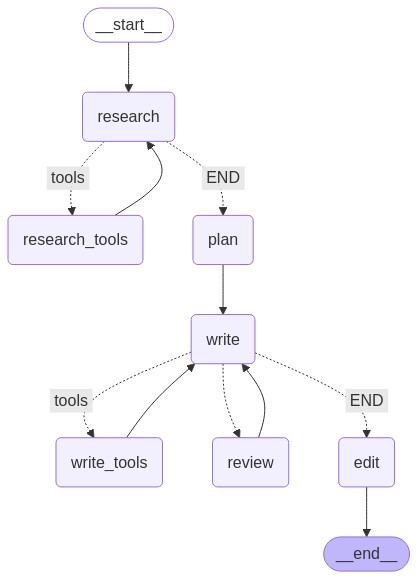

In [26]:
workflow.set_entry_point("research")
app = workflow.compile()
try:
    display(Image(app.get_graph(xray=True).draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [27]:
inputs = {
    "input": "What are the recent research works on LLM Agents for report or article generation?",
    "max_revisions": 2
}

state = AgentState(**inputs)
for s in app.stream(input=state, config={"recursion_limit": 50}):
    output = list(s.values())[0]['agent_outcome'][0].content
    print("-----"*20)

----research node----
----router----
----------------------------------------------------------------------------------------------------
----tool calling----
---- Calling arxiv with args: {'query': 'LLM Agents for report generation'} ----
---- Calling arxiv with args: {'query': 'LLM Agents for article generation'} ----
---- Calling arxiv with args: {'query': 'Large Language Models for report generation'} ----
---- Calling arxiv with args: {'query': 'Large Language Models for article generation'} ----
----------------------------------------------------------------------------------------------------
----research node----
----router----
----------------------------------------------------------------------------------------------------
----tool calling----
---- Calling write_file with args: {'file_path': 'input_docs/Enhancing LLMs for Impression Generation in Radiology Reports through a Multi-Agent System.txt', 'text': 'Title: Enhancing LLMs for Impression Generation in Radiology Repor

In [ ]:
print(output)

In [30]:
import shutil
shutil.rmtree(working_directory+'input_docs')

In [31]:
from utils.doc_writer.main import file_writer
file_writer(working_directory+"output/output_v1.docx", output)